# MNIST model recreation

This is a learning project.

MNIST digit recognition is a solved problem, hence there is no need to reinvent the wheel.

It is still a good learning resource for me as I'm familiar with the fundamentals but want to learn more about PyTorch and its workflow.

The code here is inspired by:

- [PyTorch: 'Learn the Basics' tutorial using Fashion MNIST](https://pytorch.org/tutorials/beginner/basics/intro.html).
- [Kaggle: '25 Million Images! [0.99757] MNIST' notebook](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist).
- [Kaggle: 'MNIST Digits - PyTorch CNN, ~99%' notebook](https://www.kaggle.com/code/enwei26/mnist-digits-pytorch-cnn-99).
- [Kaggle: 'CNN - Digit Recognizer (PyTorch)' notebook](https://www.kaggle.com/code/gustafsilva/cnn-digit-recognizer-pytorch/notebook)

In [182]:
# TODO: Learn more about

# Advanced techniques include:
#     - data augmentation (covered)
#     - nonlinear convolution layers (covered)
#     - learnable pooling layers (covered)
#     - ReLU activation (covered)
#     - ensembling
#     - bagging
#     - decaying learning rates (covered)
#     - dropout (covered)
#     - batch normalization (covered)
#     - adam optimization (covered)


In [183]:
import torch
import copy
import time

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor


In [199]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 35
EARLY_STOPPING_ROUNDS = 5


In [210]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = "cuda"
else:
    torch.set_default_device("cpu")
    device = "cpu"


In [209]:
torch.randn(1).device


device(type='cpu')

## Loading and augmenting data

**Data augmentation**: technique to artificially create new training data from existing training data

Augmentation is usually done online! This means that only the raw dataset is stored in the memory. When a batch of raw data is loaded, it is augmented on the fly, used for training, and then released from operative memory.

Always important to ask: does this augmentation change image labels? If yes, noise is introduced in models and performance is reduced.

Both PyTorch and TensorFlow default implementations augment only images, but not labels. For label augmentation could use [Albumentations](https://albumentations.ai/).

In [218]:
# My own data augmentation transform
train_transform1 = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

# Data augmentation transform from 'MNIST Digits - PyTorch CNN, ~99%' notebook
# Removed the Normalize step because mean and std unknown at this point
# Also removed the PIL step because it messes up other steps
train_transform2 = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[train_mean], std=[train_std]),
    ]
)

train_transform3 = transforms.Compose(
    [
        transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), translate=(0.1, 0.1)),
        ToTensor(),
    ]
)


In [219]:
# Download training and test data

training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=train_transform3
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)


In [220]:
# Check image dimensions

training_img, training_label = training_data[0]
test_img, test_label = test_data[0]

training_img.shape, test_img.shape


(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [221]:
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

len(train_dl)


938

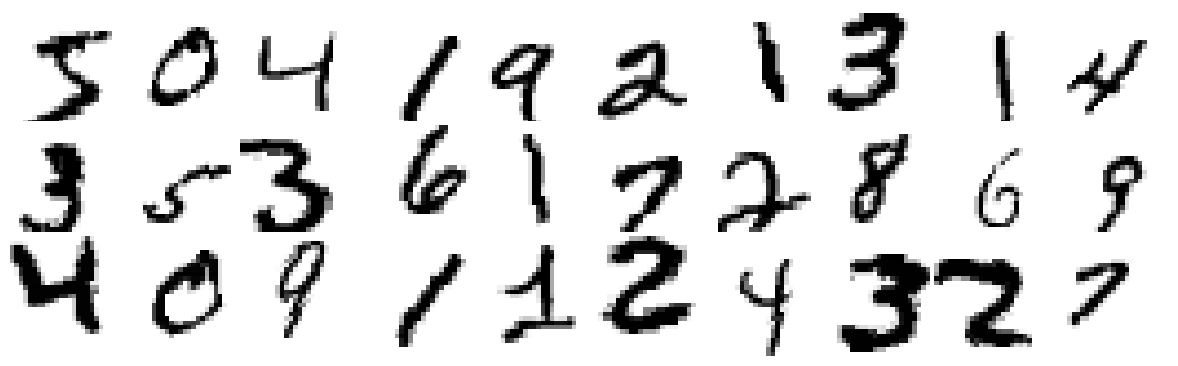

In [222]:
# Preview images and augmentations
plt.figure(figsize=(15, 4.5))

for idx in range(30):
    plt.subplot(3, 10, idx + 1)
    img, label = training_data[idx]
    plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)


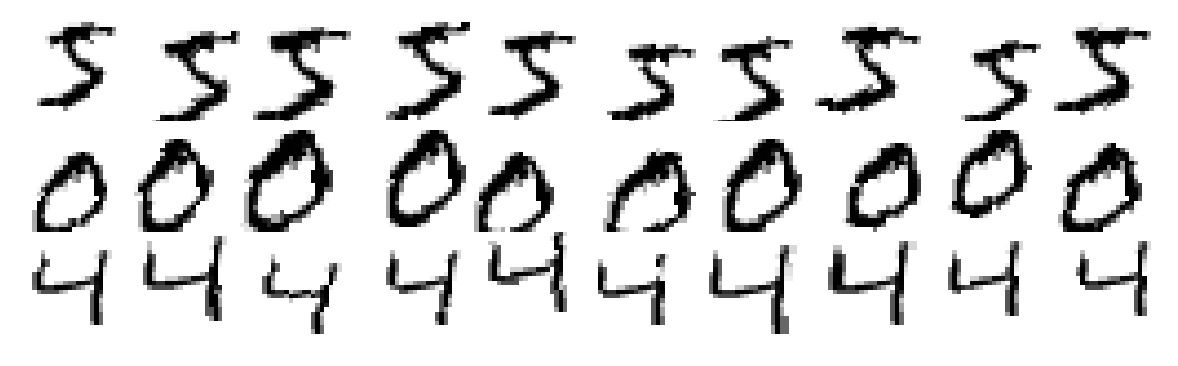

In [247]:
# Preview augmentations
plt.figure(figsize=(15, 4.5))

transform_without_totensor = transforms.RandomAffine(
    degrees=10, scale=(0.9, 1.1), translate=(0.1, 0.1)
)

for row_idx in range(3):
    img, label = training_data[row_idx]
    for col_idx in range(10):
        idx = row_idx * 10 + col_idx
        plt.subplot(3, 10, idx + 1)
        img2 = transform_without_totensor(img)
        plt.imshow(img2.reshape((28, 28)), cmap=plt.cm.binary)
        plt.axis("off")

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)


## Learning about CNN architecture components

[Kaggle: How to choose CNN Architecture MNIST](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook)

- Typical CNN architecture begins with feature extraction and finishes with classification.
    - Feature extraction is performed by alternating convolution layers with subsampling layers
    - Classification is performed with dense layers followed by a final softmax layer

In [203]:
# Architecture from PyTorch tutorial
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Architecture from the Kaggle notebook
class BetterNeuralNetwork(nn.Module):
    def __init__(self):
        super(BetterNeuralNetwork, self).__init__()

        self.conv1 = nn.Sequential(
            # Two 3x3 conv filters followed by a 5x5 stride 2 conv filter
            # Effectively a 5x5 conv with max pooling
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.4),
        )

        # Same as before with twice as many features
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.4),
        )

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dense(x)
        return x


print(BetterNeuralNetwork())


BetterNeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (7): ReL

In [204]:
model = BetterNeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_loss_history = []
test_loss_history = []
test_accuracy_history = []

best_test_loss = float("Inf")
rounds = 0

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    if epoch == 1:
        print(f"Initial epoch")

    # Training step
    train_size = len(train_dl.dataset)
    for batch, (X, y) in enumerate(train_dl):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        train_loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 100 == 0 and epoch == 1:
            current = (batch + 1) * len(X)
            print(
                f"Training loss: {train_loss.item():>7f}  [{current:>5d}/{train_size:>5d}]"
            )

    train_loss_history.append(train_loss.item())

    # Test step
    test_size = len(test_dl.dataset)
    num_batches = len(test_dl)

    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)

            # Forward pass
            pred = model(X)

            # Calculate loss (.item() gets value from tensor)
            test_loss += loss_fn(pred, y).item()

            # Calculate prediction accuracy
            test_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_accuracy /= test_size

    print(
        "Epoch: {}/{}.. ".format(epoch, EPOCHS),
        "Time: {:.2f}s..".format(time.time() - epoch_start_time),
        "Training loss: {:.3f}.. ".format(train_loss_history[-1]),
        "Test loss: {:.3f}.. ".format(test_loss),
        "Test accuracy: {:.3f}".format(test_accuracy),
    )

    # Track if test loss is decreasing and save best performing model weights
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        rounds = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        rounds += 1

    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    # Stop the training if model has not improved for a while to avoid overfitting
    if rounds >= EARLY_STOPPING_ROUNDS:
        print("Early stopping.")
        model.load_state_dict(best_model_weights)
        break


Initial epoch
Training loss: 2.311581  [   64/60000]
Training loss: 2.301655  [ 6464/60000]
Training loss: 2.299824  [12864/60000]
Training loss: 2.289170  [19264/60000]
Training loss: 2.280850  [25664/60000]
Training loss: 2.275004  [32064/60000]
Training loss: 2.221548  [38464/60000]
Training loss: 2.245828  [44864/60000]
Training loss: 2.234941  [51264/60000]
Training loss: 2.212906  [57664/60000]
Epoch: 1/2..  Time: 108.20s.. Training loss: 2.219..  Test loss: 2.202..  Test accuracy: 0.340
Epoch: 2/2..  Time: 108.48s.. Training loss: 2.041..  Test loss: 2.060..  Test accuracy: 0.553


Accuracy:

1. *NeuralNetwork* without any data augmentations and 10 epochs: ~84.5% (not converged yet)
2. *NeuralNetwork* with data augmentations from *train_transform1* and 10 epochs: ~75.5% (not converged yet)
3. *BetterNeuralNetwork* without any data augmentations and 35 epochs: ~97.6% (Google Colab run on GPU)
4. *BetterNeuralNetwork* with data augmentations from *train_transform3* (`degrees=5`) and 35 epochs: ~97.6% (Google Colab run on GPU)
5. *BetterNeuralNetwork* with data augmentations from *train_transform3* (`degrees=10`) and 35 epochs: ~97.5% (Google Colab run on GPU)
6. *BetterNeuralNetwork* with data augmentations from *train_transform3* (`degrees=0`) and 35 epochs: ~97.6% (Google Colab run on GPU)
7. *NeuralNetwork* without any data augmentations and 35 epochs: ~91.2% (Google Colab run on GPU)
8. *NeuralNetwork* with data augmentations from *train_transform1* and 35 epochs: ~84.4% (Google Colab run on GPU)
9. *NeuralNetwork* with data augmentations from *train_transform3* (`degrees=0`) and 35 epochs: ~87.8% (Google Colab run on GPU)


Increasing the random rotations lead to slower improvement and a much more unstable training loss. Not sure exactly why, but my guess is that 1's and 7's got mixed up. However, removing the rotation did not improve test accuracy.

Runtime increases approx. 2x with data augmentation transformations.

Original *NeuralNetwork* performs worse with augmentation.

In [192]:
torch.save(model, "model.pth")


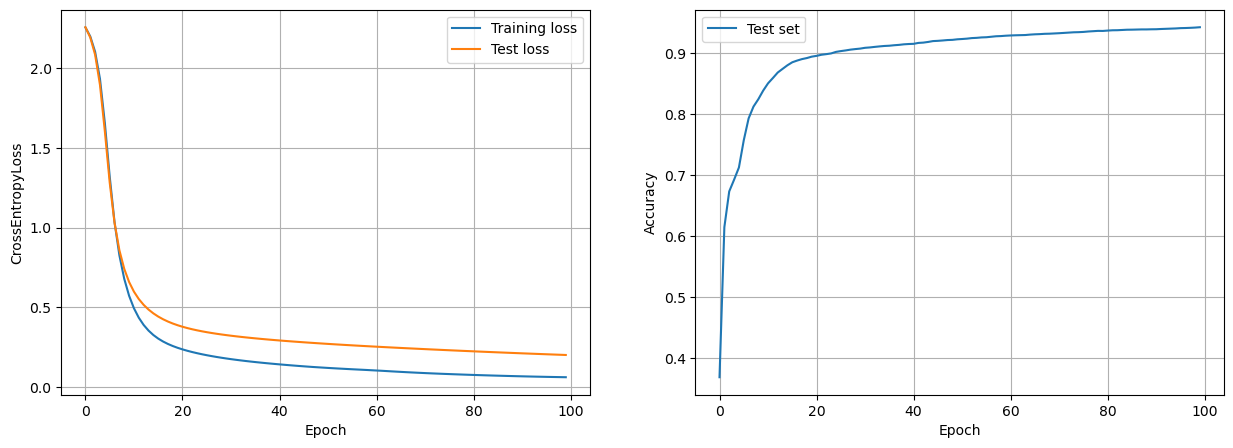

In [194]:
# Viewing training information
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_loss_history, label='Training loss')
ax1.plot(test_loss_history, label='Test loss')
ax1.grid()
ax1.set_ylabel(loss_fn.__class__.__name__)
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(test_accuracy_history, label='Test set')
ax2.grid()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()